# Predicting Car Prices

A used car service is developing an app to attract new customers. In it, you can quickly find out the market value of your car. Historical data is available: technical characteristics, configurations and prices of vehicles.

**Task:** build a model to determine the price. What matters to the customer are: the quality of prediction, the speed of prediction, the training time. To assess the quality of models, it is necessary to apply the RMSE metric, the value of the metric must be less than 2500.

**Data Description:**

*features*
* `DateCrawled` — date of downloading the profile from the database
* `VehicleType` — car body type
* `RegistrationYear` — year of car registration
* `Gearbox` — gearbox type
* `Power` — power (hp)
* `Model` — car model
* `Kilometer` — mileage (km)
* `RegistrationMonth` — month of car registration
* `FuelType` — type of fuel
* `Brand` — car brand
* `NotRepaired` — was the car under repair or not
* `DateCreated` — date of creation of the questionnaire
* `NumberOfPictures` - the number of photos of the car
* `PostalCode` — postal code of the owner of the profile (user)
* `LastSeen` — date of last user activity

*target*
* `Price` — price (EUR)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Model-selection" data-toc-modified-id="Model-selection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model selection</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#XGBRegressor" data-toc-modified-id="XGBRegressor-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>XGBRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Final-model-testing" data-toc-modified-id="Final-model-testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Final model testing</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

## Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

# regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('data/autos.csv', sep=',')

# save shape 
total_entries = df.shape[0]

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
# format columns
df.columns = [re.sub(r"(\w)([A-Z])", r"\1_\2", it).lower() for it in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [4]:
# check type of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [5]:
# delete extra columns that are not useful for analysis
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code', 'registration_month'], axis=1)
# replace the values in the not_repaired column with 1 and 0
df['not_repaired'] = df['not_repaired'].replace(['yes', 'no'], [1, 0])

,count,mean,std,min,25%,50%,75%,max
price,354369.000,4416.657,4514.159,0.000,1050.000,2700.000,6400.000,20000.000
registration_year,354369.000,2004.234,90.228,1000.000,1999.000,2003.000,2008.000,9999.000
power,354369.000,110.094,189.850,0.000,69.000,105.000,143.000,20000.000
kilometer,354369.000,128211.173,37905.342,5000.000,125000.000,150000.000,150000.000,150000.000
not_repaired,283215.000,0.127,0.333,0.000,0.000,0.000,0.000,1.000
number_of_pictures,354369.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


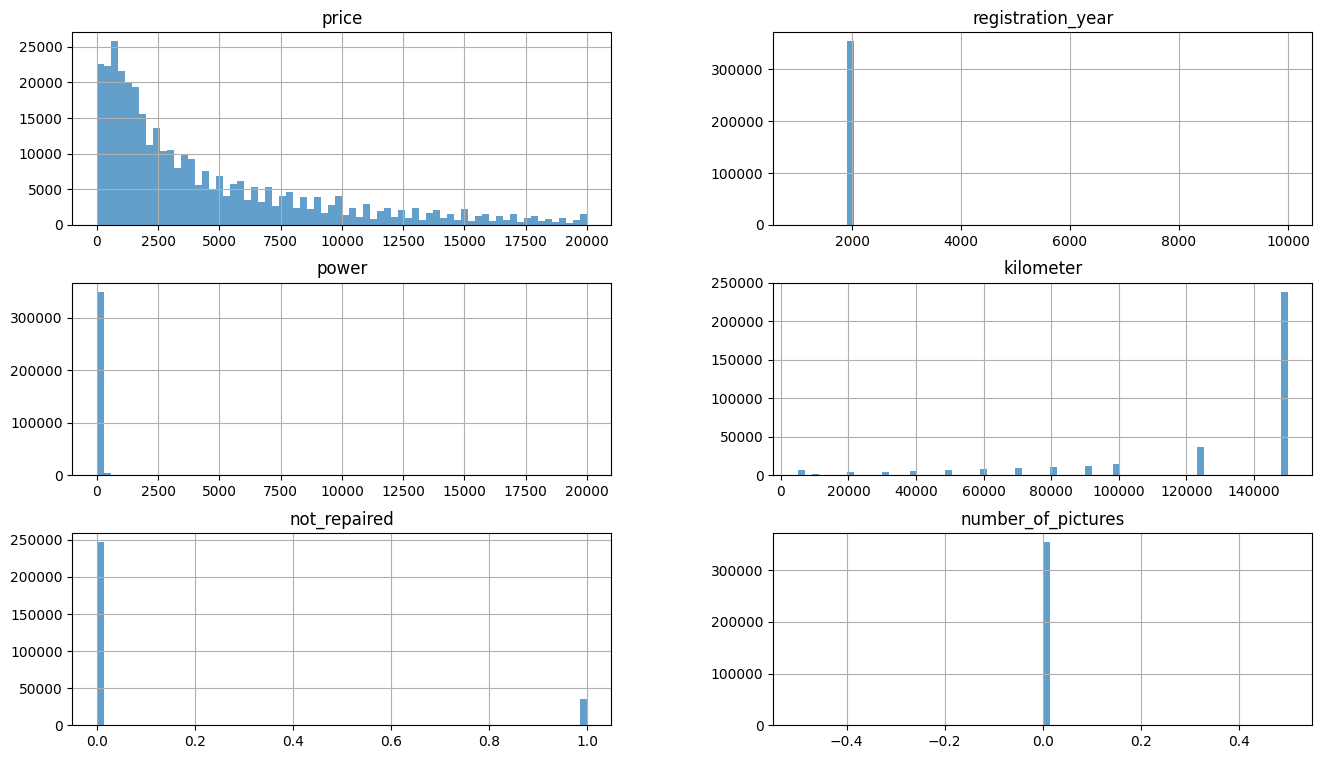

In [6]:
# check the data for anomalies
display(df.describe().T)

df.hist(figsize=(16, 9), bins=70, alpha=.7)
plt.show()

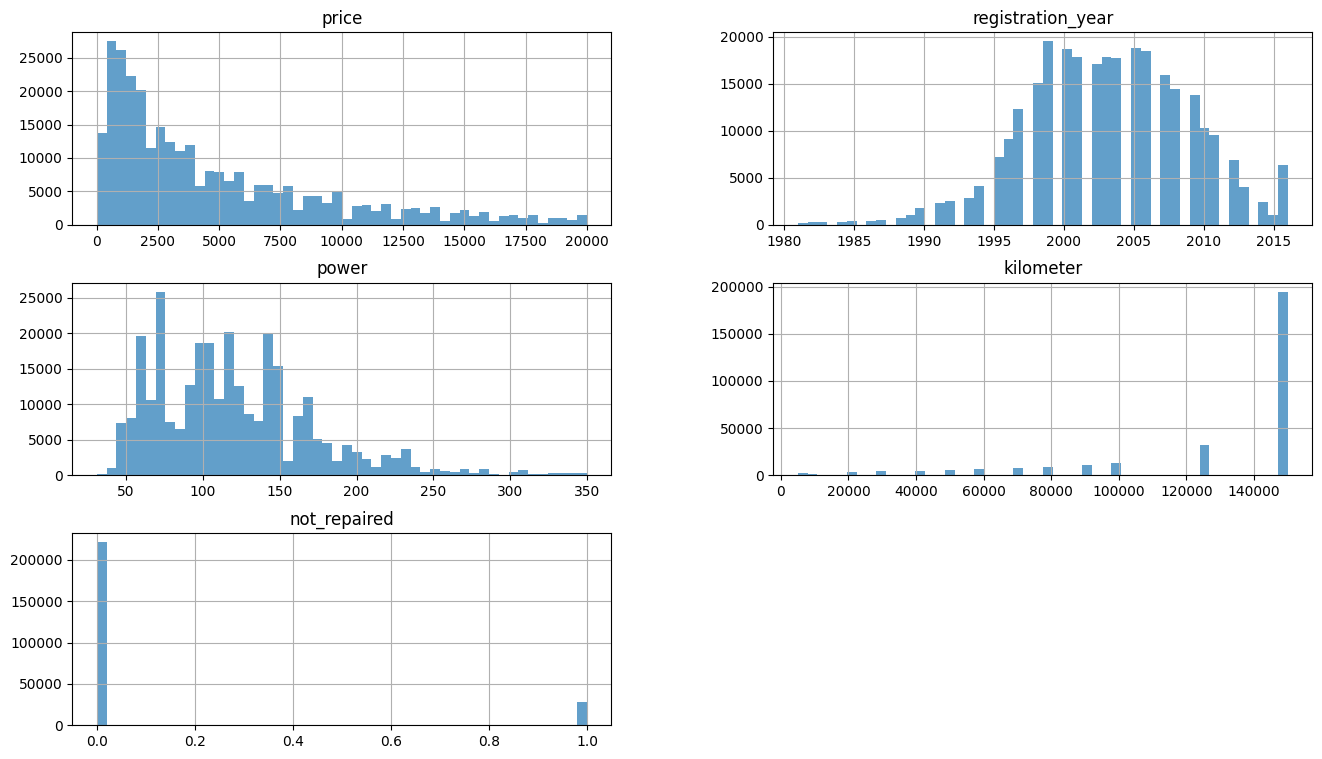

In [7]:
# remove outliers in the data, remove the number_of_pictures column there are only nulls
# most of the mileage values are 150 000 km., this can interfere with the analysis
df = df.query('price > 10 and 1980 < registration_year <= 2016 and 30 < power <= 350').reset_index(drop=True)
df = df.drop(['number_of_pictures'], axis=1)
              
# check
df.hist(figsize=(16, 9), bins=50, alpha=.7)
plt.show()

In [8]:
# empty values are in categorical variables
df.isna().mean() * 100

price                0.000
vehicle_type         3.674
registration_year    0.000
gearbox              1.763
power                0.000
model                3.550
kilometer            0.000
fuel_type            5.178
brand                0.000
not_repaired        14.372
dtype: float64

In [9]:
# look at the categorical variables and how they can be filled
print('\nbrand:\n', df.brand.value_counts(dropna=False))
print('\nmodel:\n', df.model.value_counts(dropna=False))
print('\ngearbox:\n', df.gearbox.value_counts(dropna=False))
print('\nfuel_type:\n', df.fuel_type.value_counts(dropna=False))
print('\nvehicle_type:\n', df.vehicle_type.value_counts(dropna=False))


brand:
 volkswagen        63487
opel              32155
bmw               31928
mercedes_benz     26667
audi              25368
ford              20473
renault           13853
peugeot            9383
fiat               7474
seat               5828
skoda              4933
mazda              4713
smart              4471
citroen            4151
nissan             4033
toyota             3999
hyundai            3104
mini               2955
volvo              2773
mitsubishi         2488
honda              2351
kia                2085
suzuki             1959
alfa_romeo         1926
chevrolet          1376
sonstige_autos     1250
chrysler           1141
dacia               799
subaru              641
daihatsu            615
jeep                551
porsche             533
saab                467
land_rover          444
daewoo              408
jaguar              394
lancia              365
rover               361
lada                141
trabant              21
Name: brand, dtype: int64

mode

In [10]:
# configurations are very different, so it is difficult to fill empty values with specific values
cars = pd.pivot_table(df, index=['brand', 'model', 'gearbox', 'fuel_type', 'vehicle_type'])
cars.head(20)

kilometer  not_repaired  \
brand      model gearbox fuel_type vehicle_type                            
alfa_romeo 145   manual  petrol    coupe        100000.000         0.000   
                                   other        100000.000         0.000   
                                   sedan        138750.000         0.167   
                                   small        136111.111         0.250   
           147   auto    petrol    coupe        150000.000         1.000   
                                   sedan        138461.538         0.083   
                                   small        145000.000         0.500   
                 manual  gasoline  coupe        141666.667         0.000   
                                   other        150000.000         0.500   
                                   sedan        144944.444         0.118   
                                   small        144687.500         0.167   
                                   wagon        150000.000         0.000   
                         lpg       coupe        150000.000           NaN   
                                   sedan        150000.000         0.400   
                                   small        150000.000         0.000   
                         petrol    coupe        139705.882         0.250   
                                   other        141666.667         0.000   
                                   sedan        128568.282         0.161   
                                   small        134833.333         0.311   
                                   wagon         80000.000         0.000   

                                                  power     price  \
brand      model gearbox fuel_type vehicle_type                     
alfa_romeo 145   manual  petrol    coupe        103.000   750.000   
                                   other        100.000   500.000   
                                   sedan        120.917  1560.750   
                                   small        108.889   820.611   
           147   auto    petrol    coupe        150.000   800.000   
                                   sedan        150.000  2544.923   
                                   small        150.000   938.000   
                 manual  gasoline  coupe        131.667  3023.000   
                                   other        122.000  1525.000   
                                   sedan        129.367  2754.233   
                                   small        125.125  2351.250   
                                   wagon        116.000  2499.000   
                         lpg       coupe        105.000  1600.000   
                                   sedan        124.500  1793.750   
                                   small        105.000  1900.000   
                         petrol    coupe        118.000  2200.588   
                                   other        110.000  1566.333   
                                   sedan        116.705  2464.727   
                                   small        111.117  1937.383   
                                   wagon        200.000 10950.000   

                                                 registration_year  
brand      model gearbox fuel_type vehicle_type                     
alfa_romeo 145   manual  petrol    coupe                  1999.000  
                                   other                  1995.000  
                                   sedan                  1998.500  
                                   small                  1998.111  
           147   auto    petrol    coupe                  2001.000  
                                   sedan                  2002.231  
                                   small                  2000.800  
                 manual  gasoline  coupe                  2005.333  
                                   other                  2003.500  
                                   sedan                  2004.778  
                             

In [11]:
# fill empty values with the word 'other' (it is often found among values) or the most popular value

# other values are now around 10%
df['model'] = df['model'].fillna('other')
# fill as manual as most popular
df['gearbox'] = df['gearbox'].fillna('manual')
# replace with the most popular and combine gasoline
df['fuel_type'] = df['fuel_type'].fillna('petrol').replace(['gasoline'], ['petrol']) 
# replace  other
df['vehicle_type'] = df['vehicle_type'].fillna('other') 
# replace 0 (the most popular value), but it's strange that most cars with mileage of 150 thousand were not in repair
df['not_repaired'] = df['not_repaired'].fillna(0).astype(int) 

In [12]:
# check
df.isna().mean() * 100

price               0.000
vehicle_type        0.000
registration_year   0.000
gearbox             0.000
power               0.000
model               0.000
kilometer           0.000
fuel_type           0.000
brand               0.000
not_repaired        0.000
dtype: float64

In [13]:
# leave the most popular brands and models, replace the rest with 'other'
# otherwise the model will take a very long time to train
# this will reduce the quality of the model, but at the training stage it is important for us to compare them

df['brand'] = np.where(df['brand'].map(df['brand'].value_counts()) <= 5000, 'other', df.brand)
df['model'] = np.where(df['model'].map(df['model'].value_counts()) <= 5000, 'other', df.model)

print('\nbrand:\n', df.brand.value_counts(dropna=False))
print('\nmodel:\n', df.model.value_counts(dropna=False))


brand:
 volkswagen       63487
other            55448
opel             32155
bmw              31928
mercedes_benz    26667
audi             25368
ford             20473
renault          13853
peugeot           9383
fiat              7474
seat              5828
Name: brand, dtype: int64

model:
 other       172366
golf         24607
3er          17302
polo         10655
corsa        10087
astra         9063
a4            8769
passat        8764
c_klasse      7282
5er           7053
e_klasse      5815
a3            5242
focus         5059
Name: model, dtype: int64


In [14]:
# check and remove duplicates
print('sum of duplicates:', df.duplicated().sum())

df = df.drop_duplicates().reset_index(drop=True)

sum of duplicates: 52207


In [15]:
# check how many rows we removed
print('original df:', total_entries)
print('final df:', df.shape[0])
print('deleted rows, %:', (round((df.shape[0] / total_entries - 1)*100,0)))

original df: 354369
final df: 239857
deleted rows, %: -32.0


32% of the rows have been removed, half of them are duplicates (because we removed the columns that made the row unique - date of creation, upload, last activity), so this is ok for our project

In [16]:
# check final df
df.sample(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
201074,9299,other,2010,manual,122,golf,90000,petrol,volkswagen,0
15342,4650,bus,2006,auto,150,other,150000,petrol,opel,0
130434,7680,wagon,2006,manual,140,a4,150000,petrol,audi,0
44933,1500,sedan,1999,manual,88,other,125000,petrol,other,0
214047,2999,sedan,1999,manual,101,golf,150000,petrol,volkswagen,1


**CONCLUSION**

- uploaded data on the sale of cars: prices, specifications, equipment
- empty values are filled with the most frequently occurring value or category 'other'
- removed outliers and anomalous values, uninformative columns and duplicates
- in total, 32% of rows were deleted, which we consider acceptable for such a volume of data

some columns require clarification from the customer:
- more than half of the values in the 'kilometer' column are equal to 150 thousand km, which means that there may be cars with more mileage, I would like to see this and take it into account in the model
- in the 'not_repaired' column, most cars are not repaired, despite the fact that most cars are with high mileage, the quality of the values of this column is questionable
- columns have empty values and 'other' values, how can they be minimized

## Model selection

In [17]:
# select a list of categorical variables 
categories = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

In [18]:
# split features and target
features = df.drop(['price'], axis=1)
target = df['price']

In [19]:
# split into training (60%), validation (20%) and test sets (20%)
features_train, features_valid, target_train, target_valid = train_test_split(
                                            features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test= train_test_split(
                                            features_valid, target_valid, test_size=0.5, random_state=12345)

In [20]:
# check the size of the samples
print('TRAIN')
print('features_train:', features_train.shape)
print('target_train:', target_train.shape)
print('VALID')
print('features_valid:', features_valid.shape)
print('target_valid:', target_valid.shape)
print('TEST')
print('features_test:', features_test.shape)
print('target_test:', target_test.shape)

TRAIN
features_train: (143914, 9)
target_train: (143914,)
VALID
features_valid: (47971, 9)
target_valid: (47971,)
TEST
features_test: (47972, 9)
target_test: (47972,)


In [21]:
# make a table to compare the results of the models
data =[
       ['LinearRegression', None, None, None],
       ['DecisionTreeRegressor', None, None, None], 
       ['RandomForestRegressor', None, None, None],
       ['XGBRegressor', None, None, None],
       ['LGBMRegressor', None, None, None]
      ]

model_results = pd.DataFrame(data, columns=['model', 'RMSE', 'fit_time', 'predict_time'])
model_results

,model,RMSE,fit_time,predict_time
0,LinearRegression,None,None,None
1,DecisionTreeRegressor,None,None,None
2,RandomForestRegressor,None,None,None
3,XGBRegressor,None,None,None
4,LGBMRegressor,None,None,None


### LinearRegression

In [22]:
# use One-Hot Encoding to transform categorical variables for a linear model
# in order not to fall into the dummy trap, use the argument drop_first=True
features_train_dum = pd.get_dummies(features_train, columns=categories, drop_first=True)
features_valid_dum = pd.get_dummies(features_valid, columns=categories, drop_first=True)
features_test_dum = pd.get_dummies(features_test, columns=categories, drop_first=True)

# now we have 39 columns (due to the large number of car models)
print(features_train_dum.shape)
features_train_dum.head()

(143914, 39)


,registration_year,power,kilometer,not_repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_5er,model_a3,model_a4,model_astra,model_c_klasse,model_corsa,model_e_klasse,model_focus,model_golf,model_other,model_passat,model_polo,fuel_type_electric,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_bmw,brand_fiat,brand_ford,brand_mercedes_benz,brand_opel,brand_other,brand_peugeot,brand_renault,brand_seat,brand_volkswagen
69330,2006,170,150000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
14665,2010,75,50000,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
44649,1996,100,150000,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
194157,2000,193,150000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
137046,1998,75,125000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [23]:
%%time
start = time.time()

model_lr = LinearRegression()
model_lr.fit(features_train_dum, target_train)

end = time.time()
model_results.iloc[0,2] = round(end - start, 3)

CPU times: user 1.18 s, sys: 157 ms, total: 1.34 s
Wall time: 443 ms


In [24]:
%%time
start = time.time()

predictions = model_lr.predict(features_valid_dum)

end = time.time()
model_results.iloc[0,3] = round(end - start, 3)

CPU times: user 105 ms, sys: 76.7 ms, total: 182 ms
Wall time: 43 ms


In [25]:
result = MSE(target_valid, predictions)**0.5
model_results.iloc[0,1] = round(result)
print("RMSE:", round(result, 3))

RMSE: 2719.751


In [26]:
model_results.loc[0]

model           LinearRegression
RMSE                        2720
fit_time                   0.443
predict_time               0.043
Name: 0, dtype: object

the model works fast, but the final RMSE is above the threshold of 2500

### DecisionTreeRegressor

In [27]:
# use OrdinalEncoder for the rest of the models
# otherwise there are too many columns and the models will take a long time to train
enc = OrdinalEncoder(dtype=int)
enc.fit(df[categories])

features_train[categories] = enc.transform(features_train[categories])
features_valid[categories] = enc.transform(features_valid[categories])
features_test[categories] = enc.transform(features_test[categories])

features_test.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
35376,4,2008,1,150,4,125000,5,5,0
166316,3,2002,1,44,10,150000,5,2,0
5929,2,1992,1,45,12,150000,5,10,0
19629,4,1997,1,60,9,150000,5,10,0
217331,7,2010,1,160,3,150000,5,0,0


In [28]:
%%time

parameters = {
    'max_depth': [10, 15, 20]
}

model_dt = DecisionTreeRegressor()
gs = GridSearchCV(model_dt, parameters, scoring='neg_root_mean_squared_error', cv=2)
gs.fit(features_train, target_train)

print(gs.best_score_*(-1))
print(gs.best_params_)

2018.4383334434956
{'max_depth': 10}
CPU times: user 998 ms, sys: 22.4 ms, total: 1.02 s
Wall time: 1.02 s


In [29]:
%%time
start = time.time()

best_model_dt = DecisionTreeRegressor(**gs.best_params_, random_state=12345)
best_model_dt.fit(features_train, target_train)

end = time.time()
model_results.iloc[1,2] = round(end - start, 3)

CPU times: user 190 ms, sys: 2.02 ms, total: 192 ms
Wall time: 190 ms


In [30]:
%%time
start = time.time()

predictions = best_model_dt.predict(features_valid)

end = time.time()
model_results.iloc[1,3] = round(end - start, 3)

CPU times: user 8.53 ms, sys: 1.83 ms, total: 10.4 ms
Wall time: 8.82 ms


In [31]:
result = MSE(target_valid, predictions)**0.5
model_results.iloc[1,1] = round(result)
print("RMSE:", round(result, 3))
print('model parameters:', best_model_dt)

RMSE: 2004.569
model parameters: DecisionTreeRegressor(max_depth=10, random_state=12345)


In [32]:
model_results.loc[1]

model           DecisionTreeRegressor
RMSE                             2005
fit_time                        0.190
predict_time                    0.009
Name: 1, dtype: object

### RandomForestRegressor

In [33]:
%%time

parameters = {
    'n_estimators': [300, 350],
    'max_depth': [15, 20]
}

model_rf = RandomForestRegressor()
gs = GridSearchCV(model_rf, parameters, scoring='neg_root_mean_squared_error', cv=2)
gs.fit(features_train, target_train)

print(gs.best_score_)
print(gs.best_params_)

-1764.190807860783
{'max_depth': 15, 'n_estimators': 350}
CPU times: user 5min 17s, sys: 2.95 s, total: 5min 20s
Wall time: 5min 21s


In [34]:
%%time
start = time.time()

best_model_rf = RandomForestRegressor(**gs.best_params_, random_state=12345)
best_model_rf.fit(features_train, target_train)

end = time.time()
model_results.iloc[2,2] = round(end - start, 3)

CPU times: user 58.2 s, sys: 346 ms, total: 58.5 s
Wall time: 58.9 s


In [35]:
%%time
start = time.time()
# сделаем предсказания
predictions = best_model_rf.predict(features_valid) 

end = time.time()
model_results.iloc[2,3] = round(end - start, 3)

CPU times: user 2.43 s, sys: 6.27 ms, total: 2.44 s
Wall time: 2.44 s


In [36]:
result = MSE(target_valid, predictions)**0.5
model_results.iloc[2,1] = round(result)
print("RMSE:", round(result, 3))
print('model parameters:', best_model_rf)

RMSE: 1737.118
model parameters: RandomForestRegressor(max_depth=15, n_estimators=350, random_state=12345)


In [37]:
model_results.loc[2]

model           RandomForestRegressor
RMSE                             1737
fit_time                       58.870
predict_time                    2.439
Name: 2, dtype: object

### XGBRegressor

In [38]:
%%time

parameters = {
    'n_estimators': [50, 150],
    'max_depth': [7, 10]
}

model_xgb = XGBRegressor()
gs = GridSearchCV(model_xgb, parameters, scoring='neg_root_mean_squared_error', cv=2)
gs.fit(features_train, target_train)

print(gs.best_score_)
print(gs.best_params_)

-1706.7438516705274
{'max_depth': 7, 'n_estimators': 150}
CPU times: user 3min 25s, sys: 3.28 s, total: 3min 28s
Wall time: 18.5 s


In [39]:
%%time
start = time.time()

best_model_xgb = XGBRegressor(**gs.best_params_, random_state=12345)
best_model_xgb.fit(features_train, target_train)

end = time.time()
model_results.iloc[3,2] = round(end - start, 3)

CPU times: user 47.2 s, sys: 899 ms, total: 48.1 s
Wall time: 4.38 s


In [40]:
%%time
start = time.time()

predictions = best_model_xgb.predict(features_valid) 

end = time.time()
model_results.iloc[3,3] = round(end - start, 3)

CPU times: user 344 ms, sys: 7.16 ms, total: 351 ms
Wall time: 31.4 ms


In [41]:
result = MSE(target_valid, predictions)**0.5
model_results.iloc[3,1] = round(result)
print("RMSE:", round(result, 3))
print('model parameters:', best_model_xgb)

RMSE: 1693.245
model parameters: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, ...)


In [42]:
model_results.loc[3]

model           XGBRegressor
RMSE                    1693
fit_time               4.375
predict_time           0.031
Name: 3, dtype: object

### LGBMRegressor

In [43]:
%%time

parameters = {
    'n_estimators': [400, 550],
    'max_depth': [15, 20]
}

model_lgm = LGBMRegressor()
gs = GridSearchCV(model_lgm, parameters, scoring='neg_root_mean_squared_error', cv=2)
gs.fit(features_train, target_train)

print(gs.best_score_)
print(gs.best_params_)

-1685.2465340626784
{'max_depth': 15, 'n_estimators': 550}
CPU times: user 1min 48s, sys: 2.51 s, total: 1min 51s
Wall time: 10.1 s


In [44]:
%%time
start = time.time()

best_model_lgm = LGBMRegressor(**gs.best_params_, random_state=12345)
best_model_lgm.fit(features_train, target_train)

end = time.time()
model_results.iloc[4,2] = round(end - start, 3)

CPU times: user 22.1 s, sys: 1.2 s, total: 23.3 s
Wall time: 2.45 s


In [45]:
%%time
start = time.time()

predictions = best_model_lgm.predict(features_valid)

end = time.time()
model_results.iloc[4,3] = round(end - start, 3)

CPU times: user 2.13 s, sys: 17.5 ms, total: 2.15 s
Wall time: 184 ms


In [46]:
result = MSE(target_valid, predictions)**0.5
model_results.iloc[4,1] = round(result)
print("RMSE:", round(result, 3))
print('model parameters:', best_model_lgm)

RMSE: 1684.163
model parameters: LGBMRegressor(max_depth=15, n_estimators=550, random_state=12345)


In [47]:
model_results.loc[4]

model           LGBMRegressor
RMSE                     1684
fit_time                2.455
predict_time            0.183
Name: 4, dtype: object

**CONCLUSION**

studied 5 regression models:
1. LinearRegression
2. DecisionTreeRegressor ('max_depth': 10)
3. RandomForestRegressor ('max_depth': 15, 'n_estimators': 350)
4. XGBRegressor ('max_depth': 7, 'n_estimators': 150)
5. LGBMRegressor ('max_depth': 15, 'n_estimators': 550)

In [48]:
# final results of models
model_results

,model,RMSE,fit_time,predict_time
0,LinearRegression,2720,0.443,0.043
1,DecisionTreeRegressor,2005,0.190,0.009
2,RandomForestRegressor,1737,58.870,2.439
3,XGBRegressor,1693,4.375,0.031
4,LGBMRegressor,1684,2.455,0.183


In [49]:
print('best by RMSE - LGBMRegressor:')
display(model_results[['model', 'RMSE']].sort_values(by='RMSE'))
print('best by fitting time - DecisionTreeRegressor:')
display(model_results[['model', 'fit_time']].sort_values(by='fit_time'))
print('best by prediction time - DecisionTreeRegressor:')
display(model_results[['model', 'predict_time']].sort_values(by='predict_time'))

best by RMSE - LGBMRegressor:


,model,RMSE
4,LGBMRegressor,1684
3,XGBRegressor,1693
2,RandomForestRegressor,1737
1,DecisionTreeRegressor,2005
0,LinearRegression,2720


best by fitting time - DecisionTreeRegressor:


,model,fit_time
1,DecisionTreeRegressor,0.190
0,LinearRegression,0.443
4,LGBMRegressor,2.455
3,XGBRegressor,4.375
2,RandomForestRegressor,58.870


best by prediction time - DecisionTreeRegressor:


,model,predict_time
1,DecisionTreeRegressor,0.009
3,XGBRegressor,0.031
0,LinearRegression,0.043
4,LGBMRegressor,0.183
2,RandomForestRegressor,2.439


for further analysis, we will choose the DecisionTreeRegressor model, since it has a high learning and prediction rate and a suitable RMSE metric

## Final model testing

In [50]:
# check the accuracy of model predictions using cross-validation on the validation set
cross_val_result = cross_val_score(best_model_dt, features_train, target_train, 
                                   cv=5, scoring='neg_root_mean_squared_error')

print('cross_val_score:', np.around(cross_val_result*(-1)))
print('MEAN cross_val_score:', round(cross_val_result.mean()*(-1)))

cross_val_score: [1954. 2009. 1976. 1991. 1971.]
MEAN cross_val_score: 1980


cross-validation gives similar RMSE metrics, which means the model works the same on different samples

In [51]:
# check the RMSE metric on the test set and compare it with the metric on the validation set
predictions_test_dt = best_model_dt.predict(features_test) 
result = MSE(target_test, predictions_test_dt) ** 0.5

print("RMSE test:", round(result))
print("RMSE valid:", model_results.loc[1][1])

RMSE test: 1957
RMSE valid: 2005


RMSE metrics on test and validation data do not differ much, which means that the model works adequately

,%
registration_year,0.603
power,0.286
kilometer,0.048
brand,0.024
vehicle_type,0.024
not_repaired,0.011


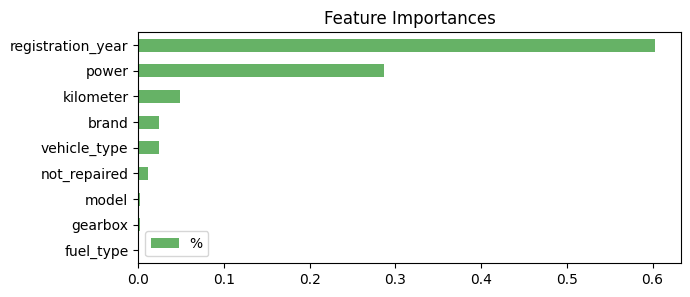

In [52]:
# let's see which features most affect the prediction of the model
feature_importances_dt = pd.DataFrame(best_model_dt.feature_importances_, 
                              index=features_valid.columns, columns=['%']).sort_values(ascending=False, by='%')

display(feature_importances_dt.head(6))

feature_importances_dt.sort_values(by='%').plot.barh(y='%', figsize=(7, 3), color='green', alpha=.6)
plt.title('Feature Importances')
plt.show()

The most important features in the model that affect the target feature - the price of the car, are:
- year of car registration
- power, h.p. 
- mileage, km.
- brand 
- car vehicle type (vehicle_type)
- was the car under repair or not

## Conclusions

**Data**

- uploaded data on the sale of cars: prices, specifications, equipment
- empty values ​​are filled with the most frequently occurring value or category 'other'
- removed outliers and anomalous values, uninformative columns and duplicates
- in total, 32% of rows were deleted, which we consider acceptable for such a volume of data, the total sample was 302 thousand observations

some columns require clarification from the customer:
- more than half of the values ​​in the 'kilometer' column are equal to 150 thousand km, which means that there may be cars with more mileage, I would like to see this and take it into account in the model
- in the 'not_repaired' column, most cars are not repaired, despite the fact that most cars are with high mileage, the quality of the values ​​of this column is questionable
- columns have empty values ​​and 'other' values, how can they be minimized

**Models**

studied 5 regression models:

In [53]:
# final model results
model_results

,model,RMSE,fit_time,predict_time
0,LinearRegression,2720,0.443,0.043
1,DecisionTreeRegressor,2005,0.190,0.009
2,RandomForestRegressor,1737,58.870,2.439
3,XGBRegressor,1693,4.375,0.031
4,LGBMRegressor,1684,2.455,0.183


- best model by RMSE metric - LGBMRegressor
- the model with the highest learning rate - DecisionTreeRegressor
- model with the highest prediction rate - DecisionTreeRegressor

**Final model**

The **DecisionTreeRegressor** model was chosen as the final model, which has a high learning and prediction rate and a low RMSE (Root Mean Square Error) metric

- cross-validation gives similar RMSE metrics, so the model works the same on different samples: cross_val_score = {1954. 2009. 1976. 1991. 1971.}, MEAN cross_val_score = 1980
- RMSE metrics on test (=2005) and validation data (=1957) do not differ much, which means that the model works adequately

The most important features in the model that affect the target feature - the price of the car, are:
- year of car registration
- power, h.p. 
- mileage, km.
- brand 
- car vehicle type (vehicle_type)
- was the car under repair or not